### Comparison of SPI outputs between Python AA pipeline and R operational script

*Sources of differences in this notebook:*


**SPI computation**

- Rounding errors in CHIRPS-based SPI

- 1980-1981 season ignored for indexes related to second part of the season (and issued during first part) ignored in Python to harmonize with other indexes

- Calibration stop (end date of historical time series used in the gamma standardization): as we identify the index using its actual year in R and using the year of the beginning of season in Python, setting a fixed calibration stop to 2018/12/31 leads to different time ranges taken in the standardization for the different indices.

- Forecast-based SPI includes some differences related to the inclusion of 2022 / 2023 forecasts in the computation of probabilities of zeros in R (SPI AM particularly)

**Bias correction**

- Quantile function in bias correction (7 instead of 8: https://numpy.org/doc/stable/reference/generated/numpy.nanquantile.html#r02de30f409d2-1)

- Interpolation between distributions of quantiles at the prediction step potentially done slightly differently

- Number of nearest neighbours at edges

In [1]:
country = 'MOZ'
issue = 10
index = 'spi'

#### GET BC SPI / PROBABILITIES REFERENCE & TEST OUTPUTS

In [2]:
import os
os.chdir('..')

In [3]:
from helper_fns import read_probas_references, read_spi_references

path_ref_obs = 'AA/data/MOZ/outputs/SPI_ALL_YEARS/SPI2/'
path_ref_ano = 'AA/data/MOZ/outputs/issued10/ECMWF_SPI/'
path_ref_spi = 'AA/data/MOZ/outputs/BiasCorrection/Empirical/bySPI.k/issued10/ECMWF_SPI/'
path_ref_bc = 'AA/data/MOZ/outputs/issued10/ECMWF_SPI_Probability/'
ref_anoobs = read_spi_references(path_ref_obs, obs=True)
ref_anofc = read_spi_references(path_ref_ano)
ref_spi = read_spi_references(path_ref_spi, bc=True)
ref_probas = read_probas_references(path_ref_bc, ['Mild', 'Moderate', 'Severe'])

In [24]:
import logging
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd

In [25]:
from AA.config.params import Params
from AA.helper_fns import read_observations_locally, read_forecasts_locally, read_triggers
from hip.analysis.analyses.drought import get_accumulation_periods, run_accumulation_index, run_gamma_standardization, \
    run_bias_correction, compute_probabilities

GDAL_DATA                    = C:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\hip-analysis-dev-env\Library\share\gdal
GDAL_DISABLE_READDIR_ON_OPEN = EMPTY_DIR
GDAL_HTTP_MAX_RETRY          = 10
GDAL_HTTP_RETRY_DELAY        = 0.5


**Get SPI/probabilities produced with Python functions**

In [26]:
observations = read_observations_locally('AA/data/MOZ/chirps')
forecasts = read_forecasts_locally('AA/data/MOZ/forecast/Moz_SAB_tp_ecmwf_10/*.nc')

params = Params(iso=country, issue=issue, index=index)

triggers_df = read_triggers(f"AA/data/{params.iso}/outputs/Plots/triggers.aa.2022")
gdf = gpd.read_file(f"AA/data/{params.iso}/shapefiles/moz_admbnda_2019_SHP/moz_admbnda_adm2_2019.shp")

accumulation_periods = get_accumulation_periods(
    forecasts, 
    params.start_season, 
    params.end_season, 
    2, 
    2,
)

In [27]:
accumulation_periods

{'ON': (10, 11),
 'ND': (11, 12),
 'DJ': (12, 1),
 'JF': (1, 2),
 'FM': (2, 3),
 'MA': (3, 4)}

In [53]:
def operational_pipeline(forecasts, observations, params, period_months):       
    # Remove 1980 season to harmonize observations between different indexes
    if int(issue) > params.end_season: # to remove when comparing anoobs 
        observations = observations.where(
            observations.time.dt.date >= datetime.date(1981, 10, 1), drop=True
        )

    # Accumulation
    accumulation_fc = run_accumulation_index(
        forecasts, params.aggregate, period_months, forecasts=True
    )
    accumulation_obs = run_accumulation_index(
        observations, params.aggregate, period_months
    )
    logging.info(f"Completed accumulation")

    # Remove inconsistent observations
    accumulation_obs = accumulation_obs.sel(
        time=slice(datetime.date(1979, 1, 1), datetime.date(params.year - 1, 12, 31))
    )

    # Anomaly
    anomaly_fc = run_gamma_standardization(
        accumulation_fc, params.calibration_start, params.calibration_stop
    )
    anomaly_obs = run_gamma_standardization(
        accumulation_obs,
        params.calibration_start,
        params.calibration_stop,
        members=False,
    )
    logging.info(f"Completed anomaly")

    # Probabilities without Bias Correction
    probabilities = compute_probabilities(
        anomaly_fc.where(anomaly_fc.time.dt.year == params.year, drop=True),
        levels=params.intensity_thresholds,
    ).round(2)

    # Bias correction
    index_bc = run_bias_correction(
        anomaly_fc, 
        anomaly_obs, 
        params.end_season,
        params.year,
        int(params.issue),
        enso=True,
    )
    logging.info(f"Completed bias correction")

    return anomaly_fc, anomaly_obs, index_bc, probabilities

In [54]:
list_index_anofc, list_index_anoobs, list_index_spibc, list_index_probs = [], [], [], []
for acc_per in accumulation_periods.values():
    anomalyfc, anomalyobs, spi, probs = operational_pipeline(forecasts, observations, params, acc_per)
    list_index_anofc.append(anomalyfc)
    list_index_anoobs.append(anomalyobs)
    list_index_spibc.append(spi)
    list_index_probs.append(probs)

c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\hip-analysis-dev-env\lib\site-packages\xclim\sdba\utils.py:316: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(
c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\hip-analysis-dev-env\lib\site-packages\xclim\sdba\utils.py:316: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(
c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\hip-analysis-dev-env\lib\site-packages\xclim\sdba\utils.py:316: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(
c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\hip-analysis-dev-env\lib\site-packages\xclim\sdba\utils.py:316: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(
c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\hip-analysis-dev-env\lib\site-packages\xclim\sdba\utils.py:316: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(
c:\Users\amine.barkaoui\AppData\Local\minicon

In [55]:
def format_xr_output(da_index, p, drop_time=True, add_year=False):
    if drop_time:
        df = da_index.to_dataframe().reset_index().drop('time', axis=1)
    else:
        df = da_index.to_dataframe().reset_index()
    df['period'] = np.repeat(p[0], len(df))

    if add_year:
        first_y = pd.to_datetime(df.time.values[0]).year
        df['time'] = [pd.to_datetime(t).year + 1 if first_y == 1980 else pd.to_datetime(t).year for t in df.time.values]
    return df

pyt_probas = pd.concat([format_xr_output(list_index_probs[i], p, drop_time=False) for i, p in enumerate(accumulation_periods.items())])
pyt_probas.columns = ['longitude', 'latitude', 'category', 'probability_test', 'period']

pyt_spibc = pd.concat([format_xr_output(list_index_spibc[i], p) for i, p in enumerate(accumulation_periods.items())])
pyt_spibc.columns = ['latitude', 'longitude', 'ensemble', 'spi_bc', 'period']

pyt_anofc = pd.concat([format_xr_output(list_index_anofc[i], p, drop_time=False, add_year=True) for i, p in enumerate(accumulation_periods.items())])
pyt_anofc.columns = ['latitude', 'longitude', 'year', 'spi', 'ensemble', 'period']

pyt_anoobs = pd.concat([format_xr_output(list_index_anoobs[i], p, drop_time=False, add_year=True) for i, p in enumerate(accumulation_periods.items())])
pyt_anoobs.columns = ['latitude', 'longitude', 'year', 'spi_obs', 'period']

In [11]:
pyt_probas2 = pyt_probas.set_index(['latitude','longitude','category','period'])
ref_probas2 = ref_probas.set_index(['latitude','longitude','category','period'])
comparison_probs = pyt_probas2.join(ref_probas2).reset_index().dropna()

In [56]:
pyt_spibc2 = pyt_spibc.set_index(['latitude','longitude','ensemble','period'])
ref_spi2 = ref_spi.set_index(['latitude','longitude','ensemble','period'])
comparison_spibc = pyt_spibc2.join(ref_spi2).reset_index().dropna()

In [13]:
pyt_anofc2 = pyt_anofc.set_index(['latitude','longitude','year','ensemble','period'])
ref_anofc2 = ref_anofc.set_index(['latitude','longitude','year','ensemble','period'])
comparison_anofc = pyt_anofc2.join(ref_anofc2).reset_index().dropna()

In [14]:
pyt_anoobs2 = pyt_anoobs.set_index(['latitude','longitude','year','period'])
ref_anoobs2 = ref_anoobs.set_index(['latitude','longitude','year','period'])
comparison_anoobs = pyt_anoobs2.join(ref_anoobs2).reset_index().dropna()

In [21]:
comparison_probs.to_csv('AA/data/MOZ/outputs/validation/spi/with_fixes/validation_comparison_probs_df_hdcobs.csv', index=False)

In [63]:
comparison_spibc.to_csv('AA/data/MOZ/outputs/validation/spi/with_fixes/validation_comparison_spi_df_hdcobs.csv', index=False)

In [24]:
comparison_anofc.to_csv('AA/data/MOZ/outputs/validation/spi/with_fixes/validation_comparison_anofc_df_hdcobs.csv', index=False)

In [43]:
comparison_anoobs.to_csv('AA/data/MOZ/outputs/validation/spi/with_fixes/validation_comparison_anoobs_df_hdcobs.csv', index=False)

### COMPARE R & PYTHON SCRIPTS AT THE PIXEL LEVEL

The difference has been computed by subtracting R references from Python outputs (Python - R)

In [64]:
comparison_probs = pd.read_csv('AA/data/MOZ/outputs/validation/spi/with_fixes/validation_comparison_probs_df_hdcobs.csv')
comparison_spi = pd.read_csv('AA/data/MOZ/outputs/validation/spi/with_fixes/validation_comparison_spi_df_hdcobs.csv')
comparison_anofc = pd.read_csv('AA/data/MOZ/outputs/validation/spi/with_fixes/validation_comparison_anofc_df_hdcobs.csv')
comparison_anoobs = pd.read_csv('AA/data/MOZ/outputs/validation/spi/with_fixes/validation_comparison_anoobs_df_hdcobs.csv')

In [36]:
def plot_hist(comparison, title, xlabel, xmin, xmax, s=1, mask_text=False):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize = (6,4))

    quant_5, quant_25, quant_50, quant_75, quant_95 = comparison.difference.quantile(0.05), comparison.difference.quantile(0.25), comparison.difference.quantile(0.5), comparison.difference.quantile(0.75), comparison.difference.quantile(0.95)

    # [quantile, opacity, length]
    quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]

    comparison.difference.plot(kind='hist', density = True, alpha = 0.65, bins=200)
    comparison.difference.plot(kind='kde')

    # Plot the lines with a loop
    import matplotlib.pyplot as plt
    for i in quants: plt.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

    # X
    ax.set_xlabel(xlabel)
    ax.set_xlim(xmin, xmax) 

    # Y
    ax.set_yticklabels([])
    ax.set_ylabel("")

    if not(mask_text):
        plt.text(quant_5-.01, 0.15 * s, "5th", size = 10, alpha = 0.8)
        plt.text(quant_25-.013, 0.27 * s, "25th", size = 11, alpha = 0.85)
        plt.text(quant_50-.013, 0.33 * s, "50th", size = 12, alpha = 1)
        plt.text(quant_75-.013, 0.39 * s, "75th", size = 11, alpha = 0.85)
        plt.text(quant_95-.025, 0.47 * s, "95th Percentile", size = 10, alpha =.8)

    # Overall
    ax.grid(False)
    ax.set_title(title, size = 17, pad = 10)

    # Remove ticks and spines
    ax.tick_params(left = False, bottom = False)
    for ax, spine in ax.spines.items():
        spine.set_visible(False)

In [57]:
comparison_probs['difference'] = comparison_probs['probability_test'] - comparison_probs['probability_ref']
comparison_spibc['difference'] = comparison_spibc['spi_bc'] / 1000 - comparison_spibc['spi_ref']
comparison_anofc['difference'] = comparison_anofc['spi'] / 1000 - comparison_anofc['spi_ref']
comparison_anoobs['difference'] = comparison_anoobs['spi_obs'] / 1000 - comparison_anoobs['spi_ref']

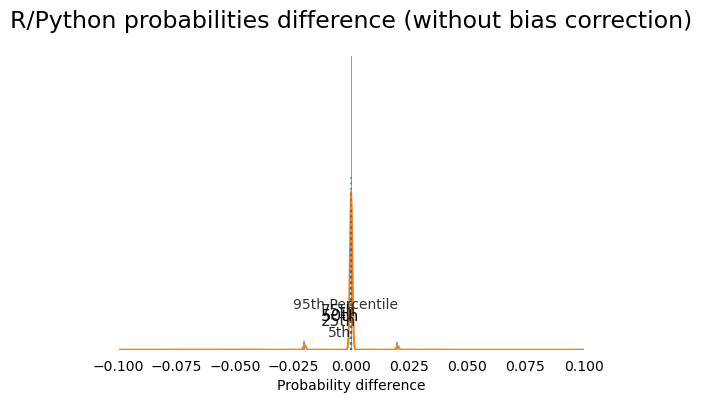

In [41]:
plot_hist(comparison_probs, title="R/Python probabilities difference (without bias correction)", xlabel="Probability difference", xmin=-.1, xmax=.1, s=400)

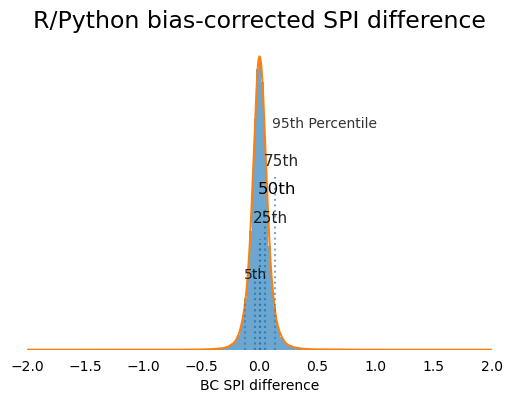

In [61]:
plot_hist(comparison_spibc, title="R/Python bias-corrected SPI difference", xlabel="BC SPI difference", xmin=-2, xmax=2, s=10)

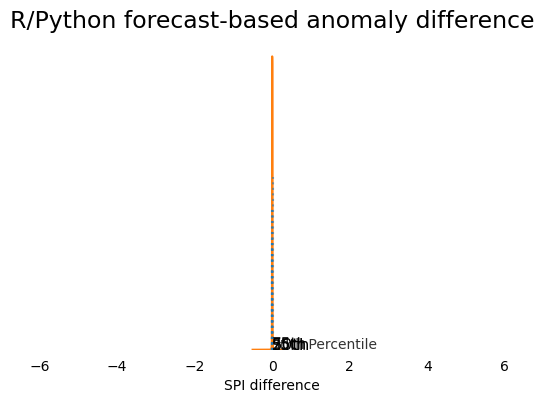

In [23]:
plot_hist(comparison_anofc, title="R/Python forecast-based anomaly difference", xlabel="SPI difference", xmin=-6, xmax=6, s=0.3)

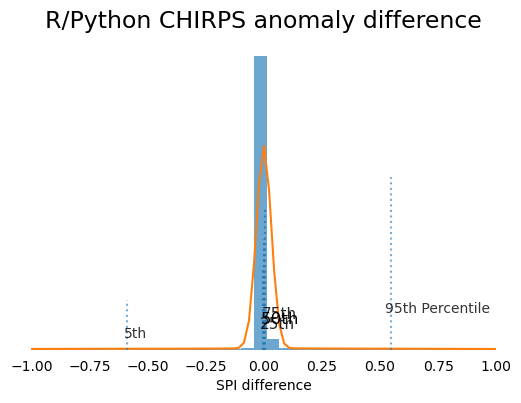

In [42]:
plot_hist(comparison_anoobs, title="R/Python CHIRPS anomaly difference", xlabel="SPI difference", xmin=-1, xmax=1, s=4)

In [77]:
def map_difference_mean(comparison, title, crange):
    from shapely import Point
    import matplotlib.pyplot as plt
    mean_comparison = comparison.groupby(['latitude', 'longitude']).mean().reset_index()
    geometry = [Point(row.longitude, row.latitude) for i, row in mean_comparison.iterrows()]
    comparison_gdf = gpd.GeoDataFrame(mean_comparison, geometry=geometry)
    comparison_gdf.plot('difference', cmap='bwr', legend=True, vmin=-crange, vmax=crange)
    plt.title(title)

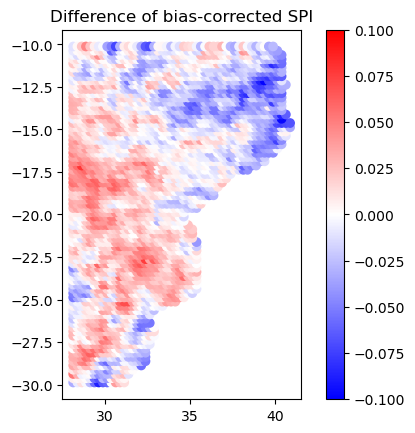

In [81]:
map_difference_mean(comparison_spi.drop(['period'], axis=1), 'Difference of bias-corrected SPI', crange=.1)

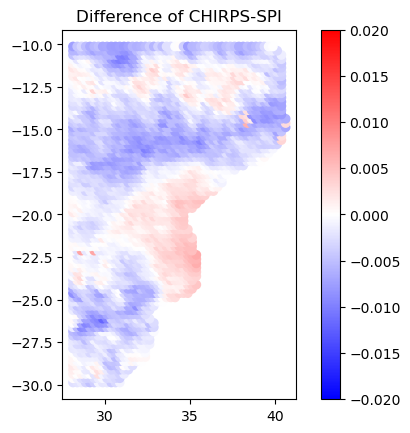

In [84]:
map_difference_mean(comparison_anoobs.drop(['period'], axis=1), 'Difference of CHIRPS-SPI', crange=.02)